### Predicting the outcome of 2012 US presidential election.

In [1]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

C:\Users\guhemant\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#mapping between states and abbreviations
states_abbrev = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [3]:
#adapted from  https://github.com/dataiap/dataiap/blob/master/resources/util/map_util.py

#load in state geometry
state2poly = defaultdict(list)

data = json.load(file("data/us-states.json"))
for f in data['features']:
    state = states_abbrev[f['id']]
    geo = f['geometry']
    if geo['type'] == 'Polygon':
        for coords in geo['coordinates']:
            state2poly[state].append(coords)
    elif geo['type'] == 'MultiPolygon':
        for polygon in geo['coordinates']:
            state2poly[state].extend(polygon)

            
def draw_state(plot, stateid, **kwargs):
    """
    draw_state(plot, stateid, color=..., **kwargs)
    
    Automatically draws a filled shape representing the state in
    subplot.
    The color keyword argument specifies the fill color.  It accepts keyword
    arguments that plot() accepts
    """
    for polygon in state2poly[stateid]:
        xs, ys = zip(*polygon)
        plot.fill(xs, ys, **kwargs)

        
def make_map(states, label):
    """
    Draw a cloropleth map, that maps data onto the United States
    
    Inputs
    -------
    states : Column of a DataFrame
        The value for each state, to display on a map
    label : str
        Label of the color bar

    Returns
    --------
    The map
    """
    fig = plt.figure(figsize=(12, 9))
    ax = plt.gca()

    if states.max() < 2: # colormap for election probabilities 
        cmap = cm.RdBu
        vmin, vmax = 0, 1
    else:  # colormap for electoral votes
        cmap = cm.binary
        vmin, vmax = 0, states.max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    
    skip = set(['National', 'District of Columbia', 'Guam', 'Puerto Rico',
                'Virgin Islands', 'American Samoa', 'Northern Mariana Islands'])
    for state in states_abbrev.values():
        if state in skip:
            continue
        color = cmap(norm(states.ix[state]))
        draw_state(ax, state, color = color, ec='k')

    #add an inset colorbar
    ax1 = fig.add_axes([0.45, 0.70, 0.4, 0.02])    
    cb1=mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                  norm=norm,
                                  orientation='horizontal')
    ax1.set_title(label)
    remove_border(ax, left=False, bottom=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-180, -60)
    ax.set_ylim(15, 75)
    return ax

In [4]:
# I am pretending to build my model 1 month before the election
import datetime
today = datetime.datetime(2012, 10, 2)
today

datetime.datetime(2012, 10, 2, 0, 0)

In [5]:
electoral_votes = pd.read_csv("data/electoral_votes.csv").set_index('State')
electoral_votes.head()

,Votes
State,
California,55
Texas,38
New York,29
Florida,29
Illinois,20


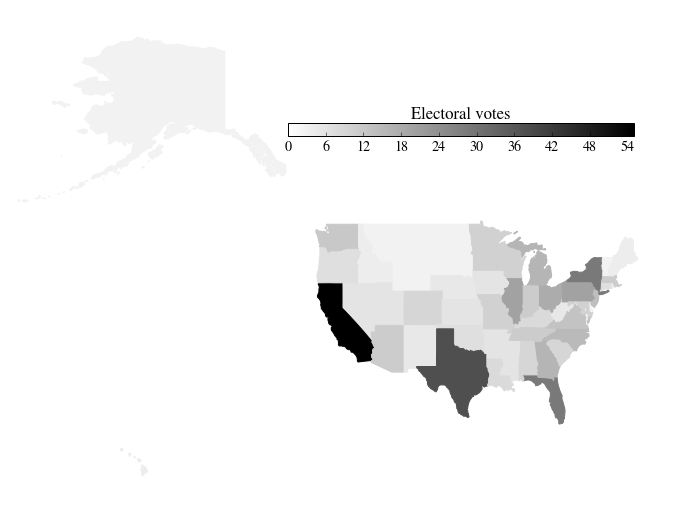

In [6]:
make_map(electoral_votes.Votes,"Electoral votes" );

In [7]:
predictwise = pd.read_csv('data/predictwise.csv').set_index('States')
predictwise.head()

,Obama,Romney,Votes
States,,,
Alabama,0.000,1.000,9
Alaska,0.000,1.000,3
Arizona,0.062,0.938,11
Arkansas,0.000,1.000,6
California,1.000,0.000,55


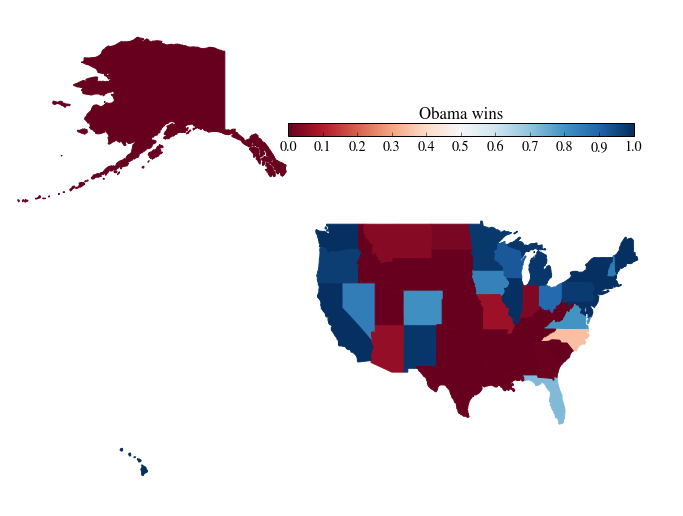

In [8]:
make_map(predictwise.Obama, "Obama wins")

In [9]:
def simulate_election(model, n_sim):
    simulations = np.random.uniform(size=(51,n_sim))
    obama_votes = (simulations<model.Obama.values.reshape(-1,1))*model.Votes.values.reshape(-1,1)
    return obama_votes.sum(axis=0)

In [10]:
result = simulate_election(predictwise, 10000)
result

array([316, 341, 322, ..., 332, 318, 284], dtype=int64)

In [11]:
from __future__ import division
obama_win = 0
for i in result:
    if i >= 269:
        obama_win += 1
        
print "Probability of Obama winning: ", obama_win/10000

Probability of Obama winning:  0.9956


In [12]:
def plot_simulation(simulation):    
    plt.hist(simulation, bins=np.arange(200, 538, 1), 
             label='simulations', align='left', normed=True)
    plt.axvline(332, 0, .5, color='r', label='Actual Outcome')
    plt.axvline(269, 0, .5, color='k', label='Victory Threshold')
    p05 = np.percentile(simulation, 5.)
    p95 = np.percentile(simulation, 95.)
    iq = int(p95 - p05)
    pwin = ((simulation >= 269).mean() * 100)
    plt.title("Chance of Obama Victory: %0.2f%%, Spread: %d votes" % (pwin, iq))
    plt.legend(frameon=False, loc='upper left')
    plt.xlabel("Obama Electoral College Votes")
    plt.ylabel("Probability")
    remove_border()

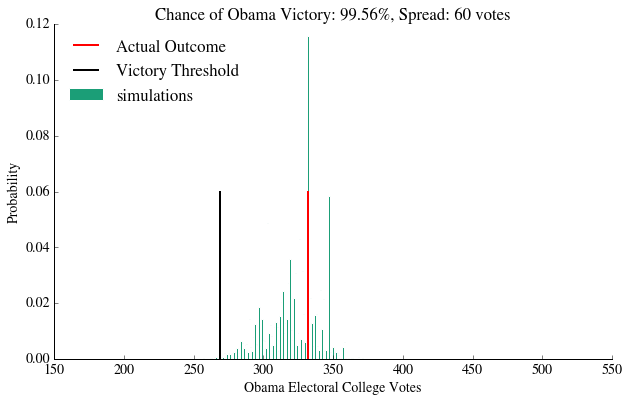

In [13]:
plot_simulation(result)

In [14]:
gallup_2012=pd.read_csv("data/g12.csv").set_index('State')
gallup_2012['Unknown'] = 100 - gallup_2012.Democrat - gallup_2012.Republican
gallup_2012.head()

,Democrat,Republican,Dem_Adv,N,Unknown
State,,,,,
Alabama,36.0,49.6,-13.6,3197,14.4
Alaska,35.9,44.3,-8.4,402,19.8
Arizona,39.8,47.3,-7.5,4325,12.9
Arkansas,41.5,40.8,0.7,2071,17.7
California,48.3,34.6,13.7,16197,17.1


In [15]:
def simple_gallup_model(model):
    return pd.DataFrame(dict(Obama = (model.Dem_Adv>0).astype(float)))

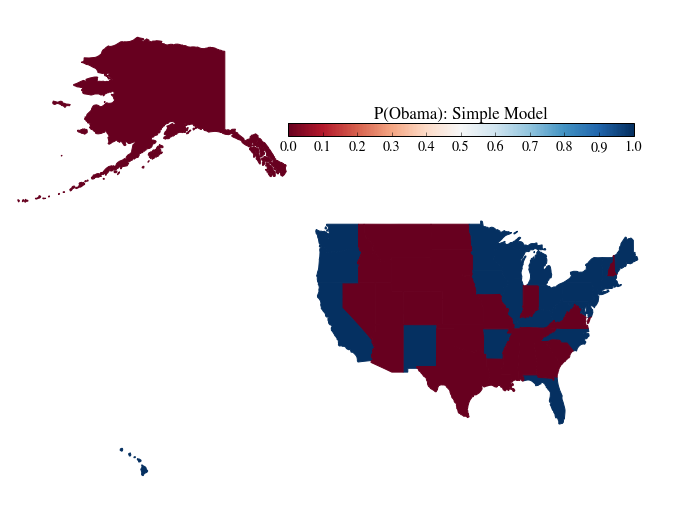

In [16]:
model = simple_gallup_model(gallup_2012)
model = model.join(electoral_votes)
predict = simulate_election(model,10000)

make_map(model.Obama, "P(Obama): Simple Model")

In [17]:
from math import sqrt
from scipy.special import erf
def uncertain_gallup_model(model, sigma = 3):
    prob = 0.5*(1 + erf(model.Dem_Adv/(sqrt(2)*sigma)))
    return pd.DataFrame(dict(Obama=prob), index=model.index)

In [18]:
model = uncertain_gallup_model(gallup_2012)
model = model.join(electoral_votes)
model.head()

,Obama,Votes
State,,
Alabama,0.000003,9
Alaska,0.002555,3
Arizona,0.006210,11
Arkansas,0.592249,6
California,0.999998,55


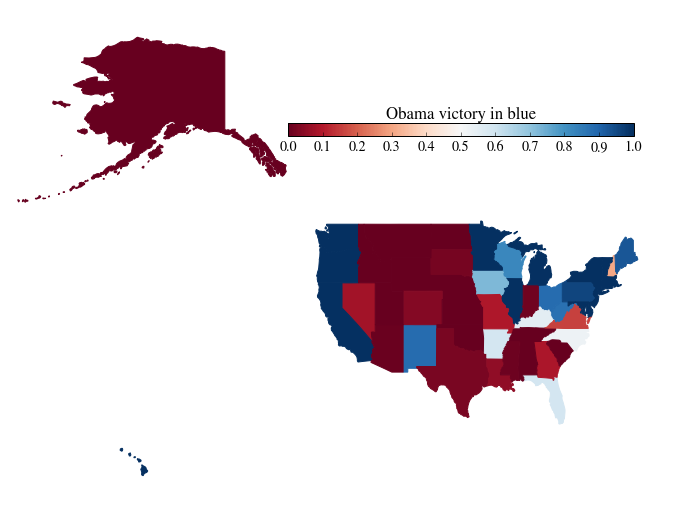

In [19]:
predict = simulate_election(model, 10000)

make_map(model.Obama, "Obama victory in blue")

###Using bias

In [20]:
def biased_gallup(model, bias, sigma = 3):
    prob = 0.5*(1 + erf((model.Dem_Adv-bias)/(sqrt(2)*sigma)))
    return pd.DataFrame(dict(Obama=prob), index=model.index)

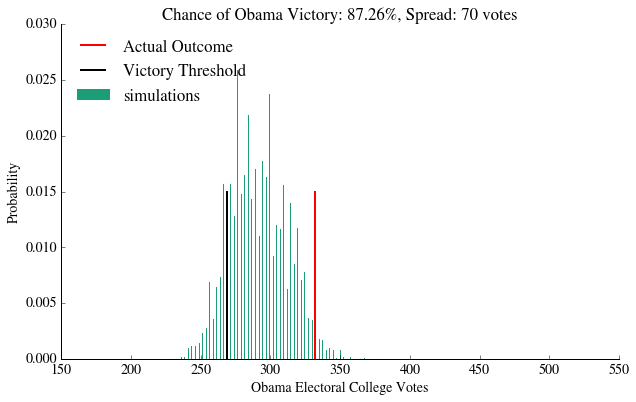

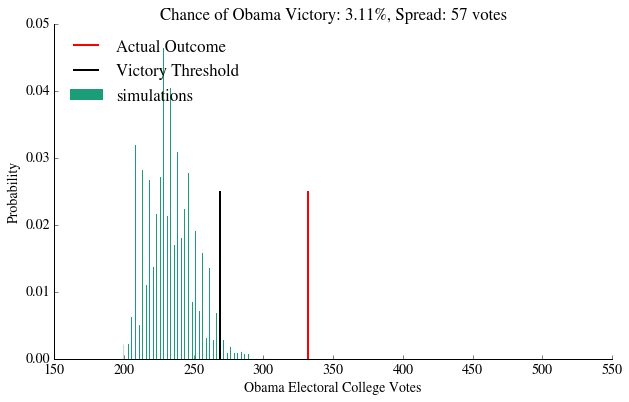

In [21]:
model = biased_gallup(gallup_2012, 1)
model = model.join(electoral_votes)
predict = simulate_election(model, 10000)
plot_simulation(predict)
plt.show()

model = biased_gallup(gallup_2012, 5)
model = model.join(electoral_votes)
predict = simulate_election(model, 10000)
plot_simulation(predict)
plt.show()

In [22]:
gallup_08 = pd.read_csv("data/g08.csv").set_index('State')
results_08 = pd.read_csv('data/2008results.csv').set_index('State')

prediction_08 = gallup_08[['Dem_Adv']]
prediction_08['Dem_Win']=results_08["Obama Pct"] - results_08["McCain Pct"]
prediction_08.head()

C:\Users\guhemant\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Dem_Adv,Dem_Win
State,,
Alabama,-0.8,-21.58
Alaska,-10.6,-21.53
Arizona,-0.4,-8.52
Arkansas,12.5,-19.86
California,19.4,24.06


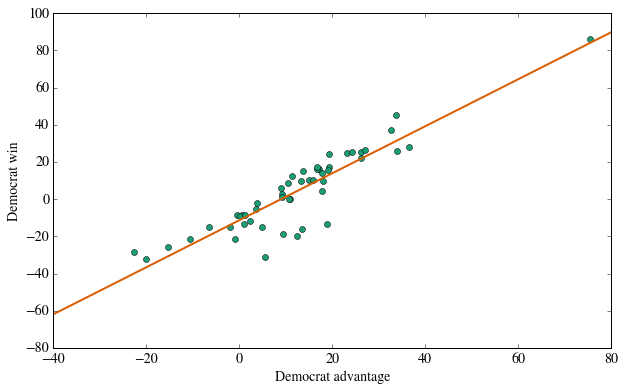

In [23]:
plt.plot(prediction_08.Dem_Adv, prediction_08.Dem_Win, 'o')
plt.xlabel('Democrat advantage')
plt.ylabel('Democrat win')
fit = np.polyfit(prediction_08.Dem_Adv, prediction_08.Dem_Win,1)
x = np.linspace(-40, 80,10)
y = np.polyval(fit, x)
plt.plot(x, y)
plt.show()

In [24]:
prediction_08[(prediction_08['Dem_Adv'] > 0) & (prediction_08['Dem_Win'] < 0)]

,Dem_Adv,Dem_Win
State,,
Arkansas,12.5,-19.86
Georgia,3.6,-5.21
Kentucky,13.5,-16.23
Louisiana,9.4,-18.63
Mississippi,1.1,-13.18
Missouri,10.9,-0.14
Montana,3.9,-2.26
North Dakota,0.6,-8.63
Oklahoma,5.6,-31.30


In [25]:
print (prediction_08.Dem_Adv - prediction_08.Dem_Win).mean()

8.06803921569


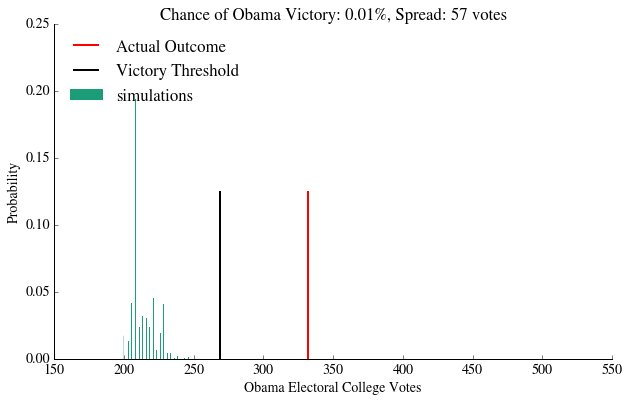

In [26]:
model = biased_gallup(gallup_2012, 8.06)
model = model.join(electoral_votes)
predict = simulate_election(model, 10000)

plot_simulation(predict)
plt.show()

#### Using The Partisan Voting Index

The Partisan Voting Index (PVI) is defined as the excessive swing towards a party in the previous election in a given state. In other words:

$$
PVI_{2008} (state) = 
Democratic.Percent_{2004} ( state ) - Republican.Percent_{2004} ( state) - \\ 
                \Big ( Democratic.Percent_{2004} (national) - Republican.Percent_{2004} (national) \Big )
$$

In [27]:
national_results = pd.read_csv("data/nat.csv").set_index('Year')
national_results.head()

,Dem,Rep
Year,,
2004,48,51
2008,53,46
2012,51,47


In [28]:
polls04 = pd.read_csv('data/p04.csv')
polls04.State = polls04.State.replace(states_abbrev)
polls04.set_index('State', inplace=True)
polls04.head()

,Dem,Rep
State,,
Alabama,37,63
Alaska,34,62
Arizona,44,55
Arkansas,45,54
California,54,45


In [29]:
pvi08=polls04.Dem - polls04.Rep - (national_results.xs(2004)['Dem'] - national_results.xs(2004)['Rep'])
pvi08.head()

State
Alabama      -23
Alaska       -25
Arizona       -8
Arkansas      -6
California    12
dtype: int64

In [43]:
e2008 = pd.DataFrame(dict(pvi = pvi08, Dem_Adv = prediction_08.Dem_Adv-prediction_08.Dem_Adv.mean(),
                         Obama_win = 1*(prediction_08.Dem_Win>0),Dem_Win = prediction_08.Dem_Win))
e2008.sort_index()
e2008.head()

,Dem_Adv,Dem_Win,Obama_win,pvi
State,,,,
Alabama,-13.154902,-21.58,0,-23
Alaska,-22.954902,-21.53,0,-25
Arizona,-12.754902,-8.52,0,-8
Arkansas,0.145098,-19.86,0,-6
California,7.045098,24.06,1,12


In [44]:
pvi12 = e2008.Dem_Win - (national_results.xs(2008)['Dem'] - national_results.xs(2008)['Rep'])
e2012 = pd.DataFrame(dict(pvi=pvi12, Dem_Adv=gallup_2012.Dem_Adv - gallup_2012.Dem_Adv.mean()))
e2012 = e2012.sort_index()
e2012.head()

,Dem_Adv,pvi
State,,
Alabama,-14.684314,-28.58
Alaska,-9.484314,-28.53
Arizona,-8.584314,-15.52
Arkansas,-0.384314,-26.86
California,12.615686,17.06


In [45]:
results2012 = pd.read_csv("data/2012results.csv")
results2012.set_index("State", inplace=True)
results2012 = results2012.sort_index()
results2012.head()

,Winner
State,
Alabama,0
Alaska,0
Arizona,0
Arkansas,0
California,1


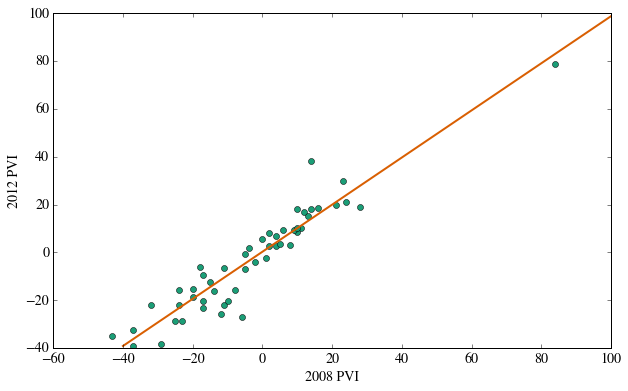

In [46]:
plt.plot(pvi08, pvi12, 'o')
plt.xlabel('2008 PVI')
plt.ylabel('2012 PVI')
fit = np.polyfit(pvi08, pvi12, 1)
x = np.linspace(-40,100, 10)
y = np.polyval(fit , x)
plt.plot(x, y)
plt.show()

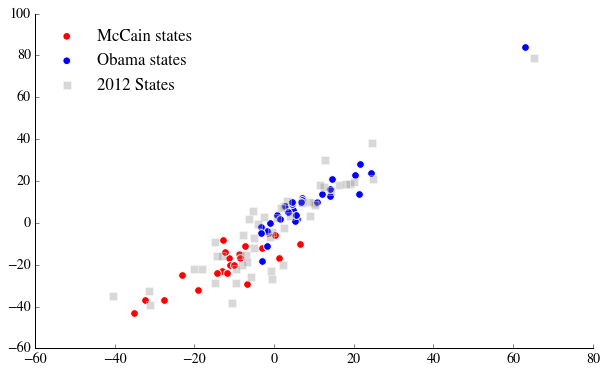

In [47]:
colors = ['red','blue']
for label in [0,1]:
    color = colors[label]
    mask = e2008.Obama_win == label
    l = 'McCain states' if label == 0 else 'Obama states'
    plt.gca().scatter(e2008[mask]['Dem_Adv'], e2008[mask]['pvi'], label = l, c=color, s = 60)
    
plt.gca().scatter(e2012['Dem_Adv'], e2012['pvi'], c='gray', s=60, 
           marker="s", label='2012 States', alpha=.3)
plt.legend(frameon=False, scatterpoints=1, loc='upper left')
remove_border()

###Using logistic regression

In [48]:
from sklearn.linear_model import LogisticRegression

def prepare_features(frame2008, featureslist):
    y= frame2008.Obama_win.values
    X = frame2008[featureslist].values
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    return y, X

In [49]:
def fit_logistic(frame2008, frame2012, featureslist, reg=0.0001):
    y, X = prepare_features(frame2008, featureslist)
    clf2 = LogisticRegression(C=reg)
    clf2.fit(X, y)
    X_new = frame2012[featureslist]
    obama_probs = clf2.predict_proba(X_new)[:, 1]
    
    df = pd.DataFrame(index=frame2012.index)
    df['Obama'] = obama_probs
    return df, clf2

In [50]:
from sklearn.grid_search import GridSearchCV

def cv_optimize(frame2008, featureslist, n_folds=10, num_p=100):
    y, X = prepare_features(frame2008, featureslist)
    clf = LogisticRegression()
    parameters = {"C": np.logspace(-4, 3, num=num_p)}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    return gs.best_params_, gs.best_score_

In [51]:
def cv_and_fit(frame2008, frame2012, featureslist, n_folds=5):
    bp, bs = cv_optimize(frame2008, featureslist, n_folds=n_folds)
    predict, clf = fit_logistic(frame2008, frame2012, featureslist, reg=bp['C'])
    return predict, clf

In [52]:
result, clf = cv_and_fit(e2008, e2012, ['Dem_Adv', 'pvi'], n_folds=5)
predict_2012 = result.join(electoral_votes)
predict_2012.head()

,Obama,Votes
State,,
Alabama,0.004367,9
Alaska,0.008462,3
Arizona,0.068250,11
Arkansas,0.033851,6
California,0.994326,55


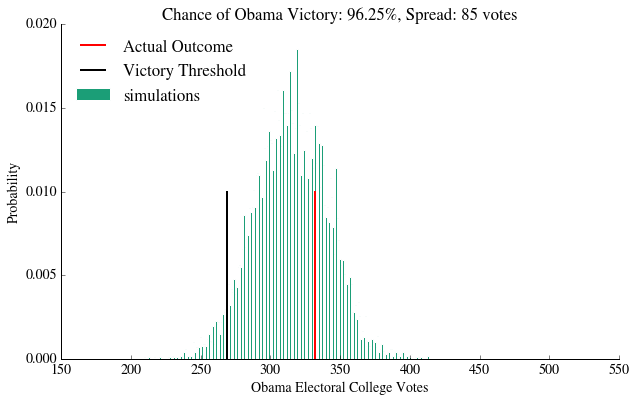

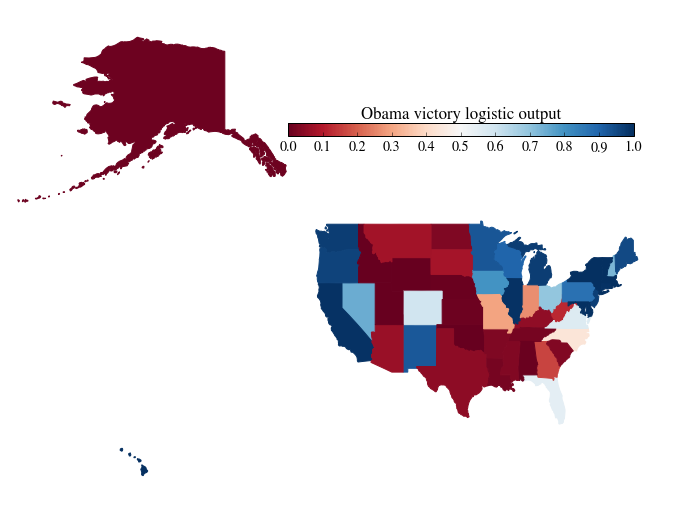

In [55]:
predict = simulate_election(predict_2012, 10000)
plot_simulation(predict)
plt.show()
make_map(predict_2012.Obama, "Obama victory logistic output")

In [100]:
multipoll = pd.read_csv('data/cleaned-state_data2012.csv', index_col=0)
multipoll.State.replace(states_abbrev, inplace=True)

multipoll.start_date = multipoll.start_date.apply(pd.to_datetime)
multipoll.end_date = multipoll.end_date.apply(pd.to_datetime)
multipoll['poll_date'] = multipoll.start_date + (multipoll.end_date - multipoll.start_date).values / 2
multipoll['age_days'] = (today - multipoll['poll_date']).values / np.timedelta64(1, 'D')
multipoll = multipoll[multipoll.age_days > 0]
multipoll = multipoll.drop(['Date', 'start_date', 'end_date', 'Spread'], axis=1)
multipoll = multipoll.join(electoral_votes, on='State')
multipoll.dropna()

print len(multipoll.State.unique())
multipoll.head()

43


,Pollster,State,MoE,Obama (D),Romney (R),Sample,obama_spread,poll_date,age_days,Votes
0,Rasmussen Reports,Washington,4.5,52.0,41.0,500.0,11.0,2012-09-26 00:00:00,6.0,12
1,Gravis Marketing,Washington,4.6,56.0,39.0,625.0,17.0,2012-09-21 12:00:00,10.5,12
2,Elway Poll,Washington,5.0,53.0,36.0,405.0,17.0,2012-09-10 12:00:00,21.5,12
3,SurveyUSA,Washington,4.4,54.0,38.0,524.0,16.0,2012-09-08 00:00:00,24.0,12
4,SurveyUSA,Washington,4.4,54.0,37.0,524.0,17.0,2012-08-01 12:00:00,61.5,12


In [94]:
def state_average(multipoll):
    std = multipoll.groupby('State').obama_spread.std()
    std[std.isnull()] = 0.05*multipoll.groupby('State').obama_spread.mean()[std.isnull()]
    return pd.DataFrame(dict(N = multipoll.groupby('State').size(),poll_mean = multipoll.groupby('State').obama_spread.mean(),
                       poll_std = std))

In [95]:
avg = state_average(multipoll).join(electoral_votes, how='outer')
avg.head()

,N,poll_mean,poll_std,Votes
State,,,,
Alabama,NaN,NaN,NaN,9
Alaska,NaN,NaN,NaN,3
Arizona,20.0,-5.500000,4.559548,11
Arkansas,3.0,-20.333333,4.041452,6
California,20.0,18.950000,5.548589,55


In [110]:
def default_missing(results):
    red_states = ["Alabama", "Alaska", "Arkansas", "Idaho", "Wyoming"]
    blue_states = ["Delaware", "District of Columbia", "Hawaii"]
    results.ix[red_states, ["poll_mean"]] = -100.0
    results.ix[red_states, ["poll_std"]] = 0.1
    results.ix[blue_states, ["poll_mean"]] = 100.0
    results.ix[blue_states, ["poll_std"]] = 0.1
default_missing(avg)
avg.head()

,N,poll_mean,poll_std,Votes
State,,,,
Alabama,NaN,-100.00,0.100000,9
Alaska,NaN,-100.00,0.100000,3
Arizona,20.0,-5.50,4.559548,11
Arkansas,3.0,-100.00,0.100000,6
California,20.0,18.95,5.548589,55


In [112]:
def aggregated_poll_model(model):
    sigma = model.poll_std
    prob = 0.5*(1 + erf(model.poll_mean/(sqrt(2)*sigma)))
    return pd.DataFrame(dict(Obama = prob, Votes = model.Votes))

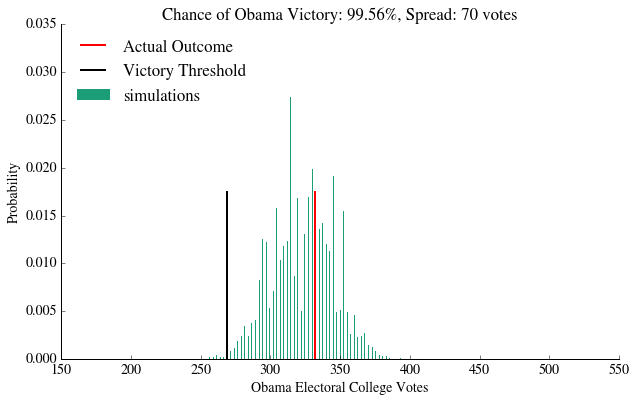

In [113]:
model = aggregate_poll_model(avg)
predict = simulate_election(model, 10000)
plot_simulation(predict)

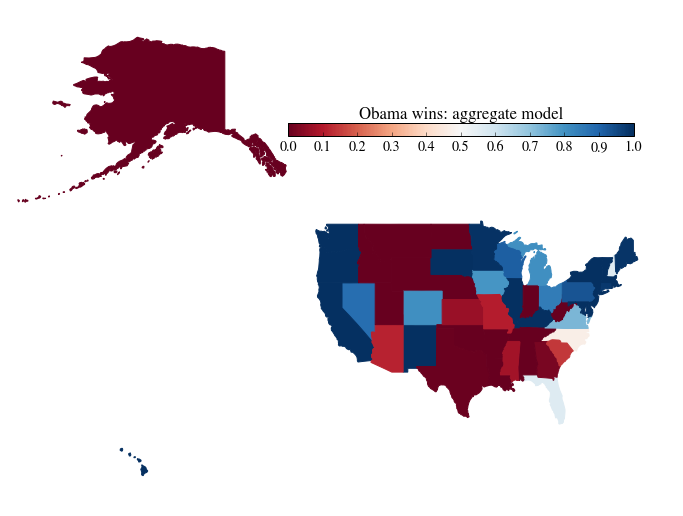

In [114]:
make_map(model.Obama, "Obama wins: aggregate model")

###Using weights

The weights $w_i$ should combine the uncertainties from the margin of error and the age of the forecast. One such combination is:

$$
w_i = \frac1{MoE^2} \times \lambda_{\rm age}
$$

where

$$
\lambda_{\rm age} = 0.5^{\frac{{\rm age}}{30 ~{\rm days}}}
$$

This model makes a few ad-hoc assumptions:

1. The equation for $\sigma$ assumes that every measurement is independent. This is not true in the case that a given pollster in a state makes multiple polls, perhaps with some of the same respondents (a longitudinal survey). But its a good assumption to start with.
1. The equation for $\lambda_{\rm age}$ assumes that a 30-day old poll is half as valuable as a current one


In [116]:
def weights(df):
    lam_age = .5 ** (df.age_days / 30.)
    w = lam_age / df.MoE ** 2
    return w

def wmean(df):
    w = weights(df)
    result = (df.obama_spread * w).sum() / w.sum()
    return result

def wsig(df):
    return df.obama_spread.std()

def weighted_state_average(multipoll):
        
    groups = multipoll.groupby('State')
    poll_mean = groups.apply(wmean)
    poll_std = groups.apply(wsig)
    poll_std[poll_std.isnull()] = poll_mean[poll_std.isnull()] * .05
    
    return pd.DataFrame(dict(poll_mean = poll_mean, poll_std = poll_std))

(250, 400)

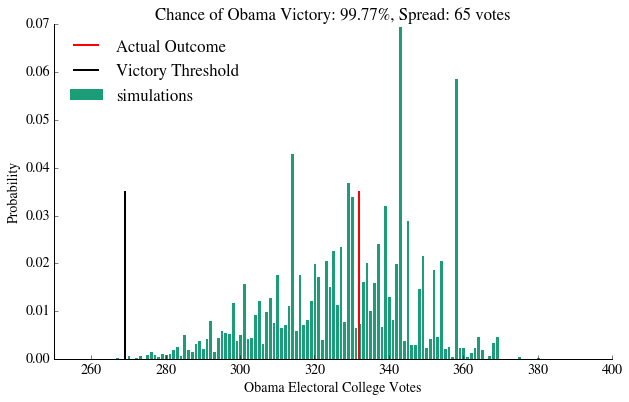

In [117]:
average = weighted_state_average(multipoll)
average = average.join(electoral_votes, how='outer')
default_missing(average)
model = aggregated_poll_model(average)
sims = simulate_election(model, 10000)
plot_simulation(sims)
plt.xlim(250, 400)

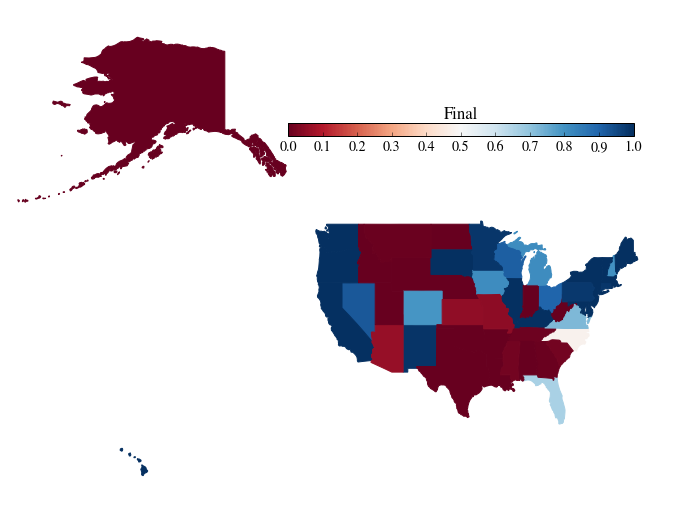

In [118]:
make_map(model.Obama, "Final")

### Actual outcome

<img src="ElectoralCollege2012.png">